In [1]:
%config InlineBackend.figure_formats = ['svg']
# %matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import dataset


## 损失函数


### 均方误差


In [3]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t)**2)


In [4]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [5]:
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
mean_squared_error(np.array(y), np.array(t))


0.09750000000000003

In [6]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
mean_squared_error(np.array(y), np.array(t))


0.5975

### 交叉熵误差


In [7]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))


In [8]:
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))


0.510825457099338

In [9]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))


2.302584092994546

In [10]:
x_train, x_test, t_train, t_test = dataset.load_mnist()


In [11]:
x_train.shape

(52500, 784)

In [12]:
x_test.shape


(17500, 784)

In [13]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
batch_mask


array([ 8304, 32979,  9175,  5928,  9928, 50541,  5924, 33045,  6505,
       10497])

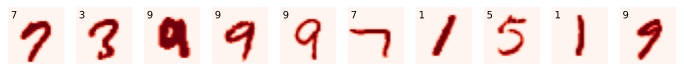

In [14]:
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]
axes = plt.figure(figsize=(12, 4)).subplots(1, 10)
for i in range(batch_size):
    axes[i].imshow(x_batch[i].reshape(28, 28), cmap=mpl.cm.Reds)

    axes[i].axis('off')
    axes[i].text(1, 5, t_batch[i], color='k')

plt.show()


In [15]:
def cross_entropy_error(y: np.ndarray, t: np.ndarray):
    if y.ndim == 1:
        y = y.reshape(1, y.size)
    if t.ndim == 1:
        t = t.reshape(1, t.size)

    batch_size = y.shape[0]
    return -np.sum(
        np.log(
            y[np.arange(batch_size), t] + 1e-7
        )
    ) / batch_size

In [16]:
y_batch = np.random.rand(10, 10)

In [17]:
cross_entropy_error(y_batch, t_batch)

1.5052134465736433

## 数值微分


In [18]:
def diff(f, x):
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2 * h)


In [19]:
import sympy
# sympy.init_printing()


In [20]:
x = sympy.Symbol("x")
y = 0.01 * x ** 2 + 0.1 * x
y


0.01*x**2 + 0.1*x

In [21]:
y_ = sympy.diff(y, x)
y_


0.02*x + 0.1

In [22]:
xx = np.linspace(0, 20, 100)
yy = sympy.lambdify(x, y, 'numpy')
yy_ = sympy.lambdify(x, y_, 'numpy')


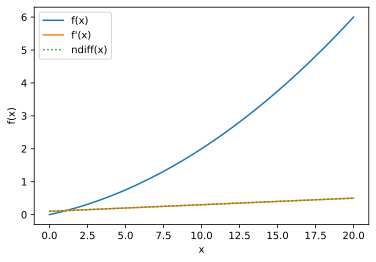

In [23]:
axes = plt.figure().add_subplot()
axes.set_xlabel("x")
axes.set_ylabel('f(x)')
axes.plot(xx, yy(xx), label='f(x)')
axes.plot(xx, yy_(xx), label='f\'(x)')
axes.plot(xx, diff(yy, xx), linestyle='dotted', label='ndiff(x)')
axes.legend()
plt.show()


### 偏导数


In [24]:
x = y = np.linspace(-10, 10, 20)
X, Y = np.meshgrid(x, y)
Z = np.array([X, Y])
Z = np.transpose(Z, (1, 2, 0))
Z.shape

(20, 20, 2)

In [25]:
def f(x: np.ndarray):
    return np.sum(x ** 2, axis=x.ndim - 1)

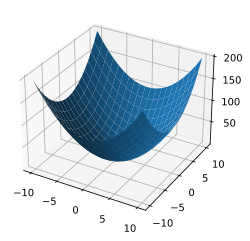

In [26]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(X, Y, f(Z))
plt.show()

## 梯度

In [27]:
def gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)  # 生成和x形状相同的数组

    for idx in range(x.size):
        tmp_val = x[idx]

        # f(x+h)的计算
        x[idx] = tmp_val + h
        fxh1 = f(x)
        # f(x-h)的计算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val  # 还原值

    return grad


In [28]:
gradient(f, np.array([3.0, 4.0]))

array([6., 8.])

In [29]:
gradient(f, np.array([0.0, 2.0]))

array([0., 4.])

In [30]:
G = np.apply_along_axis(lambda x: gradient(f, x), 2, Z)
G /= np.max(G)
G.shape

(20, 20, 2)

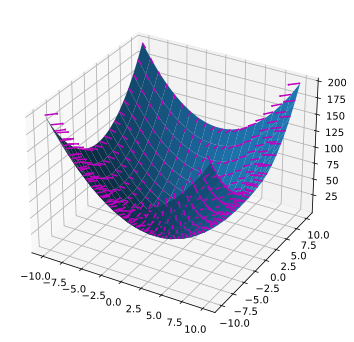

In [31]:
ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d', )
ax.plot_surface(X, Y, f(Z))
ax.quiver(X, Y, f(Z), -G[:, :, 0], -G[:, :, 1], 0, color='m', arrow_length_ratio=0.1)
plt.show()

### 梯度法

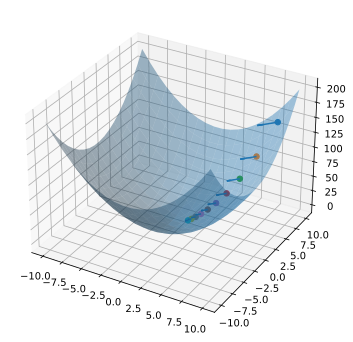

In [32]:
lr = 0.1
step = 10
x = np.array([8.0, 9.0])

ax = plt.figure(figsize=(6, 6)).add_subplot(projection='3d')
ax.plot_surface(X, Y, f(Z), alpha=0.4)

points = []
for i in range(step):
    ax.scatter(x[0], x[1], f(x), s=30)
    grad = gradient(f, x)
    ax.quiver(x[0], x[1], f(x), -grad[0] * lr, -grad[1] * lr, 0)
    x -= lr * grad

plt.show()

In [33]:
def gradient_descent(f, x, lr=0.01, step=100):

    for i in range(step):
        grad = gradient(f, x)
        x -= lr * grad

    return x

In [34]:
x = np.array([8.0, 9.0])
gradient_descent(f, x, lr=0.1)

array([1.62962878e-09, 1.83333238e-09])